In [7]:
from torch import Tensor

In [1]:
from torch import nn

In [82]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 20)
        self.h2 = nn.Linear(20, 1)

    def forward(self, xb):
        return self.h2(F.relu(self.h1(xb)))

In [83]:
mod = MyModel()

In [111]:
class MyModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 8)
        self.h2 = nn.Linear(8, 8)
        self.h3 = nn.Linear(8, 8)
        self.h4 = nn.Linear(8, 1)

    def forward(self, xb):
        res = F.tanh(self.h1(xb))
        res = F.tanh(self.h2(res))
        res = F.tanh(self.h3(res))
        res = self.h4(res)
        return res

In [112]:
mod2 = MyModel2()

In [13]:
Tensor([7])

tensor([7.])

In [14]:
mod(Tensor([7]))

tensor([2.3092], grad_fn=<AddBackward0>)

In [18]:
import torch.nn.functional as F

loss_func = F.mse_loss

In [21]:
loss_func(Tensor([7]), Tensor([6]))

tensor(1.)

In [19]:
loss_func(mod(Tensor([7])), Tensor([7]))

tensor(22.0039, grad_fn=<MseLossBackward>)

In [23]:
from torch import optim

In [84]:
opt = optim.SGD(mod.parameters(), lr=.05)

In [113]:
opt2 = optim.SGD(mod2.parameters(), lr=.01)

In [28]:
import torch

In [33]:
x = torch.rand(1000)

In [48]:
for bla in x[:10]:
    #print(mod(bla))
    print(mod(Tensor([bla])))

tensor([0.1847], grad_fn=<AddBackward0>)
tensor([0.0579], grad_fn=<AddBackward0>)
tensor([0.0846], grad_fn=<AddBackward0>)
tensor([-0.0509], grad_fn=<AddBackward0>)
tensor([0.0484], grad_fn=<AddBackward0>)
tensor([0.1020], grad_fn=<AddBackward0>)
tensor([0.0301], grad_fn=<AddBackward0>)
tensor([0.2515], grad_fn=<AddBackward0>)
tensor([0.0639], grad_fn=<AddBackward0>)
tensor([0.1835], grad_fn=<AddBackward0>)


In [52]:
from tqdm.notebook import tqdm

In [85]:
for epoch in tqdm(range(10)):
    for i in x:
        pred = mod(i.unsqueeze(0))
        loss = loss_func(pred, i.unsqueeze(0))

        loss.backward()
        opt.step()
        opt.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

In [94]:
mod(Tensor([5]))

tensor([5.2107], grad_fn=<AddBackward0>)

In [96]:
import numpy as np

In [109]:
points = [[x,mod(Tensor([x])).item()] for x in np.linspace(-10,100,1000)]

In [107]:
import matplotlib.pyplot as plt

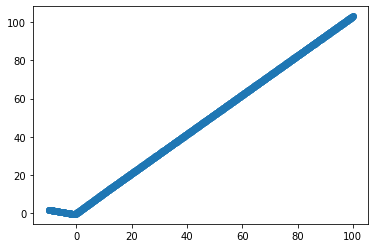

In [110]:
plt.scatter([x[0] for x in points], [x[1] for x in points])

In [114]:
for epoch in tqdm(range(10)):
    for i in x:
        pred = mod2(i.unsqueeze(0))
        loss = loss_func(pred, i.unsqueeze(0))

        loss.backward()
        opt2.step()
        opt2.zero_grad()

  0%|          | 0/10 [00:00<?, ?it/s]

/home/markus/miniconda3/envs/jupyter/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [115]:
mod2(Tensor([.3]))

tensor([0.2956], grad_fn=<AddBackward0>)

In [117]:
mod2(Tensor([-1]))

tensor([-0.6518], grad_fn=<AddBackward0>)

In [123]:
points = [[x,mod2(Tensor([x])).item()] for x in np.linspace(-2,2,1000)]

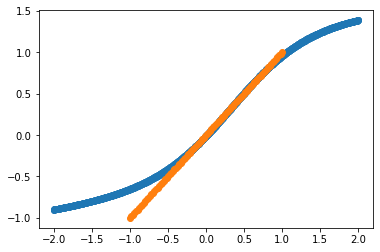

In [129]:
plt.scatter([x[0] for x in points], [x[1] for x in points])
plt.scatter(np.linspace(-1,1,100),np.linspace(-1,1,100))